# Experimental Results

- The environmental setup for these results was defined by the datasets and model hyperparameters.

- The datasets used are as follows:

1. Titanic Survival Prediction: https://www.kaggle.com/datasets/yasserh/titanic-dataset
2. Pima Diabetes: https://www.kaggle.com/datasets/jamaltariqcheema/pima-indians-diabetes-dataset
3. Loan Approval: https://www.kaggle.com/datasets/architsharma01/loan-approval-prediction-dataset
4. Mushroom Edibility: https://www.kaggle.com/datasets/uciml/mushroom-classification

- The hyperparameters for the models were as follows:

1. `ReasonGenerator`: DeepSeek-R1 model from Together AI (`temperature=0.6` and `max_tokens=4096`)

2. `ObjectiveJudge`: Claude Haiku 4.5 from Anthropic API (`temperature=0.6` and `max_tokens=4096`).

3. `ICLClassifier` and `Zero Shot CoT`: Gemini 2.5 Flash from Google Vertex AI (`temperature=0.0`, `max_tokens=4096`, and `thinking_budget=1000`)

4. `Zero Shot Prompting`: Gemini 2.5 Flash from Google Vertex AI (`temperature=0.0`, `max_tokens=4096`, and `thinking_budget=0`)

- All this configurations are available inside `scripts/constants` under the experimental setup comment.


# Importing the required modules

In [55]:
# modules used for data handling
import json
import pandas as pd
import numpy as np

# modules used for plotting
import matplotlib.pyplot as plt
import seaborn as sns

# modules used for file handling
import os

# Combine metrics from different datasets

## Structure of the final results

In [ ]:
# structure of the results
datasets = ["titanic", "diabetes", "loan", "mushroom"]
required_metrics = ["macro_f1_score", "llm_as_judge"]
approaches = ["xgboost","xai-guided-cot", "zero-shot-cot", "baseline"]

## Helper function

In [ ]:
# takes average of the
# metrics for llm as judge
def summarise_objective_metrics(metrics_log: dict) -> dict:

    # initialise the 
    # metrics
    objective_metrics = {
        "faithfulness": 0.0,
        "consistency": 0.0,
        "coherence": 0.0
    }

    # compute the average
    # of the metrics
    for row_id, row_metrics in metrics_log.items():
        for metric in objective_metrics:
            objective_metrics[metric] += row_metrics[metric]

    for metric in objective_metrics:
        objective_metrics[metric] /= len(metrics_log)
        objective_metrics[metric] = round(objective_metrics[metric], 2)

    return objective_metrics
    

## Simplify JSON structure

In [ ]:
# final results
all_metrics = dict()

# each dataset
for dataset in datasets:

    # each dataset type
    for dataset_type in ["masked", "unmasked"]:

        # load metrics log
        metrics_path = f"../data/metrics/{dataset}_{dataset_type}.json"
        key = None
        if dataset_type == "unmasked":
            key = dataset
        else:
            key = f"masked_{dataset}"

        metrics = dict(zip(approaches, [0.0] * len(approaches)))

        with open(metrics_path, "r") as f:
            metrics_log = json.load(f)

        # simplify structure
        metrics["xgboost"] = metrics_log["cot"]["xgboost"]["macro_f1_score"]
        metrics["xai-guided-cot"] = metrics_log["cot"]["xai-guided-cot"]["macro_f1_score"]
        metrics["zero-shot-cot"] = metrics_log["zero_shot_cot_ablation"]["zero-shot-cot"]["macro_f1_score"]
        metrics["baseline"] = metrics_log["zero_shot_baseline"]["zero-shot-prompting"]["macro_f1_score"]

        # only consider llm as judge
        # for unmasked datasets
        if dataset_type == "unmasked":
            metrics["llm_as_judge"] = summarise_objective_metrics(metrics_log["llm_as_judge"])

        all_metrics[key] = metrics

# save final results
json.dump(obj=all_metrics, 
          fp=open("metrics.json", "w"),
          indent=4)

We only consider the LLM-as-a-Judge results for the unmasked dataset since that is the actual use case.

# Helper functions

## Showing results as tables

In [ ]:
# displays results
# as a table
def show_results_as_table(
        results: dict, 
        datasets: list, 
        approaches: list
    ) -> pd.DataFrame:

    # filter results
    filtered_results = {k: v for k, v in results.items() if k in datasets}

    # create a table
    df = pd.DataFrame(filtered_results).T
    df.index.name = "Dataset"

    return df[approaches]

## Showing results as plots

In [89]:
# displays results
# as a  plot
def show_results_as_plots(
        results: dict, 
        datasets: list, 
        approaches: list
    ) -> None:

    # prepare data
    data = []
    for dataset in datasets:
        for approach in approaches:
            if approach in results[dataset]:
                data.append({
                    "Dataset": dataset.title(),
                    "Approach": approach.replace("-", " ").title(),
                    "Performance": results[dataset][approach]
                })

    df = pd.DataFrame(data)

    # create a bar plot
    plt.figure(figsize=(12, 6))
    x = np.arange(len(datasets))
    width = 0.2

    # plot each approach
    for i, approach in enumerate(approaches):
        approach_label = approach.replace("-", " ").title()
        values = [df[(df["Dataset"] == d.title()) & (df["Approach"] == approach_label)]["Performance"].values[0] 
                if len(df[(df["Dataset"] == d.title()) & (df["Approach"] == approach_label)]) > 0 else 0
                for d in datasets]
        plt.bar(x + i*width, values, width, label=approach_label)

    # customise the plot
    plt.xlabel("Dataset", fontsize=12)
    plt.ylabel("Performance", fontsize=12)
    plt.title("Performance Comparison Across Datasets (Unmasked Case)", fontsize=14, fontweight="bold")
    plt.xticks(x + width * 1.5, [d.title() for d in datasets])
    plt.legend(title="Approach", bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.grid(axis="y", alpha=0.3, linestyle="--")
    plt.tight_layout()
    plt.show()

# Analysis

## Load all results

In [90]:
# load metrics
with open("metrics.json", "r") as f:
    results = json.load(f)

## LLM as a Judge

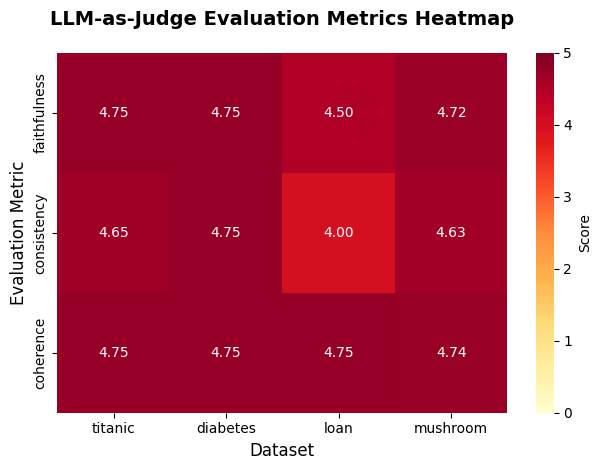

In [ ]:
# relevant metrics
datasets = ["titanic", "diabetes", "loan", "mushroom"]
metrics = ["faithfulness", "consistency", "coherence"]

# create a table
heatmap_data = dict()
for dataset in datasets:
    heatmap_data[dataset] = results[dataset]["llm_as_judge"]

df_heatmap = pd.DataFrame(heatmap_data)
df_heatmap.index.name = "Dataset"
df_heatmap.columns.name = "Evaluation Metric"

# display as a heatmap
sns.heatmap(df_heatmap, annot=True, fmt=".2f", cmap="YlOrRd", 
            cbar_kws={"label": "Score"}, vmin=0, vmax=5)
plt.title("LLM-as-Judge Evaluation Metrics Heatmap", fontsize=14, fontweight="bold", pad=20)
plt.ylabel("Evaluation Metric", fontsize=12)
plt.xlabel("Dataset", fontsize=12)
plt.tight_layout()
plt.show()

- The Objective Judge evaluation reveals consistently high reasoning quality across all datasets, with scores ranging narrowly from 4.0
to 4.75 across all three metrics.

- The ReasonGenerator component maintains high-quality scores on the Mushroom dataset (between 4.72 and 4.74) across 53 reasoning-
generation requests, comparable to those for simpler datasets like Pima Diabetes, which makes only 2 requests.

- The consistency metric has the highest variability across all the datasets, with a lowest score of 4 on the Loan Approval dataset and a highest score of 4.75 on the Pima Diabetes dataset. This highlights that, within the maximum token limit of 4096, it is difficult to focus on all influential features, especially when the decision outcome is highly subjective, and the feature space is substantial (e.g., the Loan Approval dataset).

- Faithfulness shows slight variability with the lowest score of 4.5 on the Loan Approval dataset. This suggests that accurately reflecting SHAP value signs and magnitudes in natural language is the most challenging aspect, particularly when feature relationships are nuanced. The narrow score range across all datasets suggests that the ReasonGenerator’s prompt engineering is highly effective and
robust to different dataset characteristics.

- This suggests that Deepseek-R1 can effectively convert numerical feature importances into natural language reasoning.

## Comparison with baseline (RQ2 and RQ3)

### Tabulation

In [41]:
unmasked_datasets = ["titanic", "diabetes", "loan", "mushroom"]
approaches = ["xgboost", "xai-guided-cot", "baseline"]

show_results_as_table(results, unmasked_datasets, approaches)

,xgboost,xai-guided-cot,baseline
Dataset,,,
titanic,0.748,0.779,0.755
diabetes,0.719,0.649,0.748
loan,0.973,0.822,0.621
mushroom,1.000,0.965,0.578


### Visualization

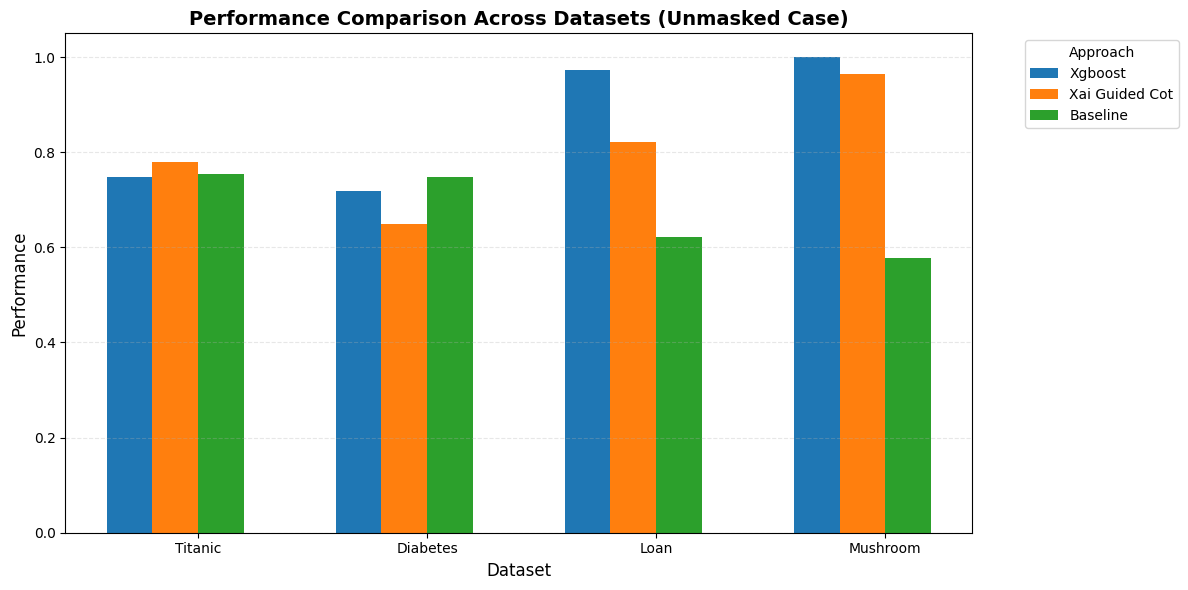

In [42]:
show_results_as_plots(results, unmasked_datasets, approaches)

### Observations

- The classification results demonstrate that XAI-Guided-CoT substantially outperforms zero-shot prompting on complex, knowledge-intensive tasks. Notably, the enhancements are particularly evident in the Mushroom dataset, where the F1-score ascends by 0.387, and in the Loan Approval dataset, where it improves by 0.201. Both cases are pivotal and statistically significant. 

- XAI-Guided-CoT achieves similar performance to that of the XGBoost model. Considering the LLM was not fine-tuned on the task, it appears that feature importances and SHAP values can transfer the knowledge learned by XGBoost model to the LLM.

- In contrast, the zero-shot baseline depends more on dataset priors than on authentic reasoning. It achieves competitive scores on Titanic (macro-F1 = 0.755) and Pima Diabetes (macro-F1 = 0.748), mainly by leveraging majority-class predictions and memorized patterns, such as the fact that most Titanic passengers perished.

- One special case is the Diabetes dataset. This dataset had an ambiguity about whether biologically impossible represent null values. These biologically impossible values were addressed in the natural language reasoning confusing the CoT LLM resulting in a drop in the macro-avg F1 score.

## Is the improvement because of CoT? (AB-1)

### Tabulation

In [43]:
unmasked_datasets = ["titanic", "diabetes", "loan", "mushroom"]
approaches = ["xai-guided-cot", "zero-shot-cot", "baseline"]

show_results_as_table(results, unmasked_datasets, approaches)

,xai-guided-cot,zero-shot-cot,baseline
Dataset,,,
titanic,0.779,0.609,0.755
diabetes,0.649,0.597,0.748
loan,0.822,0.818,0.621
mushroom,0.965,0.592,0.578


### Visualization

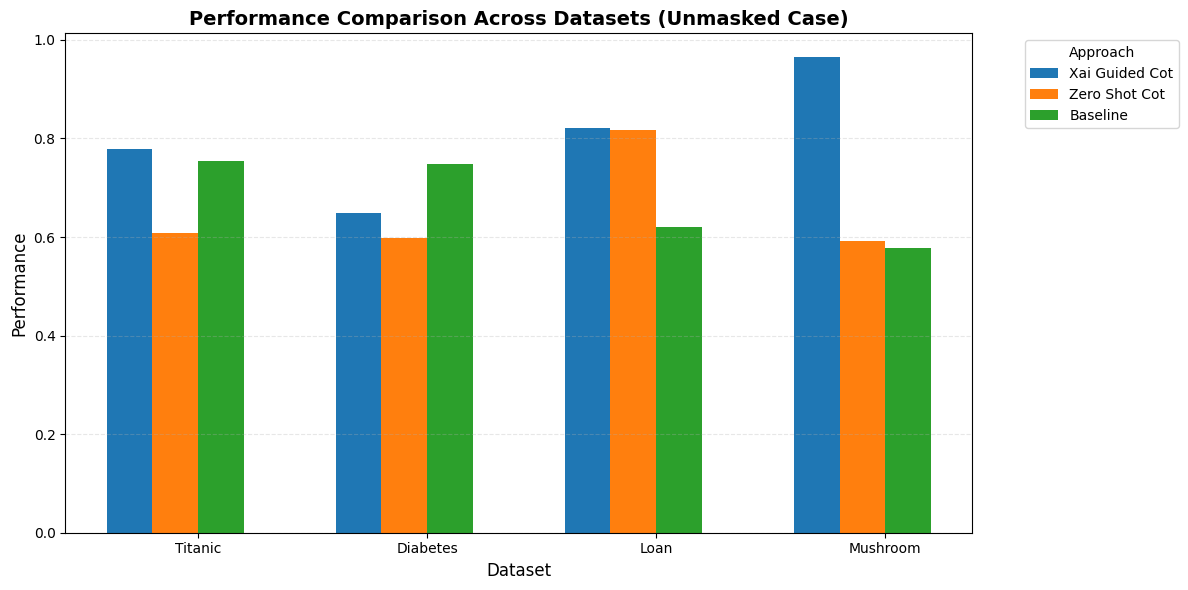

In [44]:
show_results_as_plots(results, unmasked_datasets, approaches)

### Observations

- This ablation study suggests that for the datasets at hand, XAI-Guided-CoT consistently performances better than Zero-shot CoT.
- It highlights that the improvement is not because of allowing the LLM to think alone. Therefore, the XAI attributes are contributing to the results.
- Interestingly, Zero-Shot-CoT underperforms the baseline on Titanic, implying that unstructured reasoning processes may cause the model to diverge from dataset priors.

## Is dataset metadata providing semantic context? (AB-2)

### Tabulation

In [92]:
unmasked_datasets = ["titanic", "diabetes", "loan", "mushroom"]
masked_datasets = [f"masked_{dataset}" for dataset in unmasked_datasets]
approaches = ["xai-guided-cot", "zero-shot-cot", "baseline"]

show_results_as_table(results, masked_datasets, approaches)

,xai-guided-cot,zero-shot-cot,baseline
Dataset,,,
masked_titanic,0.745,0.542,0.577
masked_diabetes,0.743,0.486,0.633
masked_loan,0.803,0.447,0.469
masked_mushroom,0.921,0.354,0.448


### Visualization

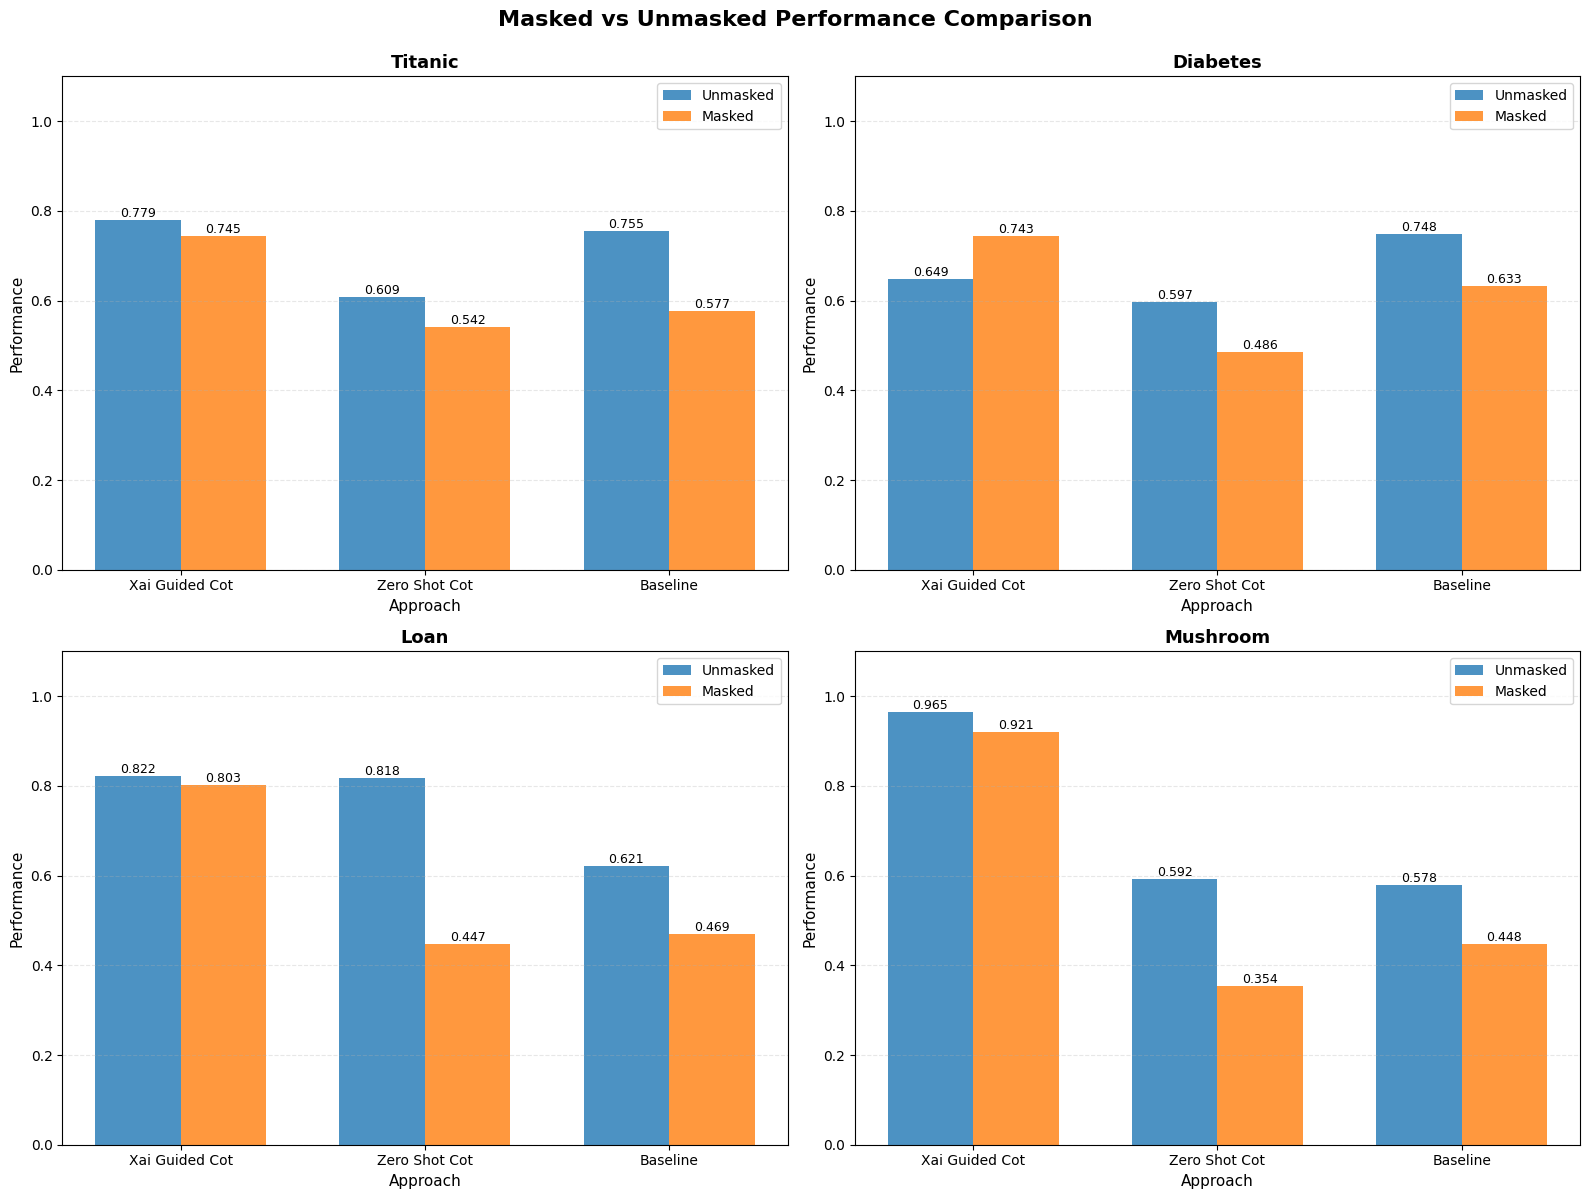

In [93]:
# Create figure with subplots
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

# Plot for each dataset
for idx, dataset in enumerate(unmasked_datasets):
    ax = axes[idx]
    
    # Get unmasked and masked results
    unmasked_data = results[dataset]
    masked_data = results[masked_datasets[idx]]
    
    # Prepare data for plotting
    x = np.arange(len(approaches))
    width = 0.35
    
    # Get values for each approach
    unmasked_values = [unmasked_data[approach] for approach in approaches]
    masked_values = [masked_data[approach] for approach in approaches]
    
    # Create bars
    bars1 = ax.bar(x - width/2, unmasked_values, width, label="Unmasked", alpha=0.8)
    bars2 = ax.bar(x + width/2, masked_values, width, label="Masked", alpha=0.8)
    
    # Customize subplot
    ax.set_xlabel("Approach", fontsize=11)
    ax.set_ylabel("Performance", fontsize=11)
    ax.set_title(f"{dataset.title()}", fontsize=13, fontweight="bold")
    ax.set_xticks(x)
    ax.set_xticklabels([a.replace("-", " ").title() for a in approaches])
    ax.legend()
    ax.grid(axis="y", alpha=0.3, linestyle="--")
    ax.set_ylim([0, 1.1])  # Adjust based on your data range
    
    # Add value labels on bars
    for bars in [bars1, bars2]:
        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height,
                   f'{height:.3f}',
                   ha='center', va='bottom', fontsize=9)

plt.suptitle("Masked vs Unmasked Performance Comparison", fontsize=16, fontweight="bold", y=0.995)
plt.tight_layout()
plt.show()

### Observations

- We can see that there are significant drops in the performance of Zero-shot prompting and Zero-shot CoT after masking the dataset metadata suggesting that the semantic context from the feature nomenclature was helping the LLM to come up with its predictions.

- The performance of XAI-Guided-CoT remains very close in both, the masked and unmasked cases. This suggests that the XAI attributes are able to help the LLM make predictions when they do not have any semantic context about the dataset metadata and its domain.

- Interestingly, the performance of XAI-Guided-CoT is better on the masked dataset than the unmasked dataset. This is because the LLM is unaware about what the column means and is not able to detect the biologically impossible values. Therefore, this ambiguity is not discussed in the natural language reasoning and CoT LLM considers it as a valid input.